Hand Gesture Classification - Multi-feature Approach
Calibrating class prototypes...
Number of images found: 40
Successfully processed images: 40

GLOBAL ACCURACY: 0.4000 (40.00%)

Class    Precision    Recall       F1-Score     Support   
------------------------------------------------------------
0        0.2500       0.2500       0.2500       4         
1        0.0000       0.0000       0.0000       4         
2        0.6000       0.7500       0.6667       4         
3        0.5000       0.5000       0.5000       4         
4        0.0000       0.0000       0.0000       4         
5        1.0000       0.5000       0.6667       4         
6        0.5000       0.5000       0.5000       4         
7        0.2000       0.2500       0.2222       4         
8        0.4000       0.5000       0.4444       4         
9        0.3750       0.7500       0.5000       4         


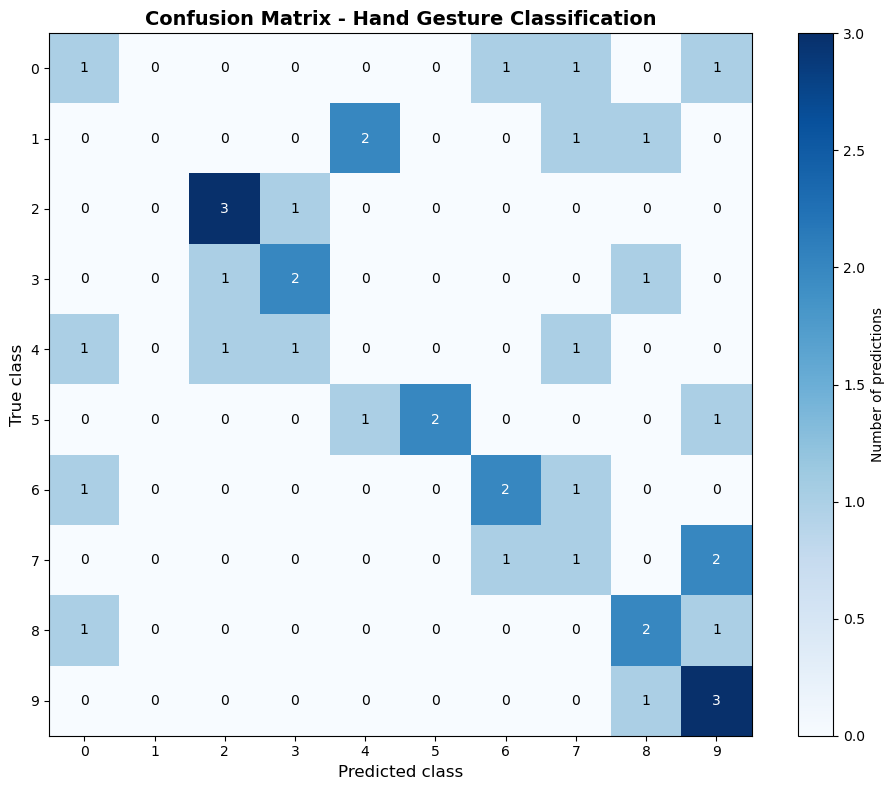

In [1]:
# IMPORT LIBRARIES
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob


# GENERAL PARAMETERS
IMG_SIZE = 128
NUM_CLASSES = 10


# COMBINED FEATURE EXTRACTION : Extracts robust features for hand gesture classification/ Combines multiple classical computer vision techniques
def extract_hand_features(path):

    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Image not found: {path}")
    
    # Resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # CONTOUR FEATURES (CANNY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    
    edge_density = np.sum(edges > 0)
    edge_ratio = edge_density / (IMG_SIZE * IMG_SIZE)
    
    vertical_profile = np.sum(edges, axis=0)
    horizontal_profile = np.sum(edges, axis=1)
    
    vertical_variance = np.var(vertical_profile)
    horizontal_variance = np.var(horizontal_profile)
    
    # HU MOMENTS (SHAPE INVARIANTS)
    moments = cv2.moments(edges)
    hu_moments = cv2.HuMoments(moments).flatten()
    # Log transform for value stabilization
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
    
    # TEXTURE ANALYSIS (HISTOGRAM)
    hist = cv2.calcHist([gray], [0], None, [16], [0, 256])
    hist = hist.flatten() / hist.sum()  # Normalization
    hist_entropy = -np.sum(hist * np.log2(hist + 1e-10))
    hist_mean = np.mean(gray)
    hist_std = np.std(gray)
    
    # GRADIENT ANALYSIS (SOBEL)
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobelX**2 + sobelY**2)
    
    gradient_mean = np.mean(gradient_magnitude)
    gradient_std = np.std(gradient_magnitude)
    
    # SHAPE ANALYSIS (CONTOURS)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        # Largest contour (hand)
        main_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(main_contour)
        perimeter = cv2.arcLength(main_contour, True)
        
        # Area/perimeter ratio (compactness)
        compactness = (perimeter ** 2) / (area + 1e-6)
        
        # Bounding box
        x, y, w, h = cv2.boundingRect(main_contour)
        aspect_ratio = float(w) / (h + 1e-6)
        extent = area / (w * h + 1e-6)
        
        # Convex hull
        hull = cv2.convexHull(main_contour)
        hull_area = cv2.contourArea(hull)
        solidity = area / (hull_area + 1e-6)
    else:
        area = 0
        perimeter = 0
        compactness = 0
        aspect_ratio = 1
        extent = 0
        solidity = 0
    
    # FINAL FEATURE VECTOR
    features = np.array([
        edge_density,
        edge_ratio,
        vertical_variance,
        horizontal_variance,
        hu_moments[0],
        hu_moments[1],
        hu_moments[2],
        hist_entropy,
        hist_mean,
        hist_std,
        gradient_mean,
        gradient_std,
        area,
        perimeter,
        compactness,
        aspect_ratio,
        extent,
        solidity
    ])
    
    return features


# CLASS THRESHOLD LEARNING (CALIBRATION) : Analyzes features for each class and computes statistics
def calibrate_thresholds(test_folder="dataset/Test"):
    
    class_features = {i: [] for i in range(NUM_CLASSES)}

    #search in the "Test" folder all the ".jpg" files
    image_paths = glob.glob(os.path.join(test_folder, "*.jpg"))
    
    for img_path in image_paths:
        try:
            class_label = int(os.path.basename(img_path).split('_')[0])
            features = extract_hand_features(img_path)
            class_features[class_label].append(features)
        except Exception as e:
            print(f"Calibration error: {e}")
    
    # Compute class means
    class_means = {}
    for c in range(NUM_CLASSES):
        if len(class_features[c]) > 0:
            class_means[c] = np.mean(class_features[c], axis=0)
        else:
            class_means[c] = np.zeros(18)
    
    return class_means


# CLASSIFICATION BY DISTANCE TO PROTOTYPES : Classifies by finding the closest class (Euclidean distance)
def classify_gesture(features, class_means):

    min_distance = float('inf')
    predicted_class = 0
    
    for c in range(NUM_CLASSES):
        distance = np.linalg.norm(features - class_means[c])
        if distance < min_distance:
            min_distance = distance
            predicted_class = c
    
    return predicted_class


# CLASS EXTRACTION FROM FILENAME : Extracts the class (C) from filename format C_P_T.jpg
def extract_class_from_filename(filename):

    basename = os.path.basename(filename)
    class_label = int(basename.split('_')[0])
    return class_label


# TEST FOLDER CLASSIFICATION : Applies classification to all images in the Test folder
def classify_test_set(test_folder="dataset/Test"):

    # Step 1: Calibration (compute class prototypes)
    print("Calibrating class prototypes...")
    class_means = calibrate_thresholds(test_folder)
    
    # Step 2: Classification
    image_paths = glob.glob(os.path.join(test_folder, "*.jpg"))
    
    if len(image_paths) == 0:
        raise ValueError(f"No images found in {test_folder}")
    
    print(f"Number of images found: {len(image_paths)}")
    
    y_true = []
    y_pred = []
    
    for img_path in sorted(image_paths):
        try:
            true_class = extract_class_from_filename(img_path)
            features = extract_hand_features(img_path)
            predicted_class = classify_gesture(features, class_means)
            
            y_true.append(true_class)
            y_pred.append(predicted_class)
            
        except Exception as e:
            print(f"Error for {os.path.basename(img_path)}: {e}")
    
    print(f"Successfully processed images: {len(y_true)}")
    
    return np.array(y_true), np.array(y_pred)


# METRICS COMPUTATION : Computes accuracy, precision and recall for each class
def compute_metrics(y_true, y_pred):

    accuracy = np.mean(y_true == y_pred)
    print(f"\n{'='*60}")
    print(f"GLOBAL ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"{'='*60}\n")
    
    print(f"{'Class':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-" * 60)
    
    for c in range(NUM_CLASSES):
        tp = np.sum((y_true == c) & (y_pred == c))
        fp = np.sum((y_true != c) & (y_pred == c))
        fn = np.sum((y_true == c) & (y_pred != c))
        support = np.sum(y_true == c)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"{c:<8} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f} {support:<10}")
    
    return accuracy


# CONFUSION MATRIX : Displays the confusion matrix
def plot_confusion_matrix(y_true, y_pred):

    confusion = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=int)
    
    for true, pred in zip(y_true, y_pred):
        confusion[true, pred] += 1
    
    plt.figure(figsize=(10, 8))
    plt.imshow(confusion, cmap='Blues', interpolation='nearest')
    plt.colorbar(label='Number of predictions')
    plt.xlabel('Predicted class', fontsize=12)
    plt.ylabel('True class', fontsize=12)
    plt.title('Confusion Matrix - Hand Gesture Classification', fontsize=14, fontweight='bold')
    
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            plt.text(j, i, str(confusion[i, j]), 
                     ha='center', va='center',
                     color='white' if confusion[i, j] > confusion.max()/2 else 'black')
    
    plt.xticks(range(NUM_CLASSES))
    plt.yticks(range(NUM_CLASSES))
    plt.tight_layout()
    plt.show()


# MAIN EXECUTION
if __name__ == "__main__":
    print("Hand Gesture Classification - Multi-feature Approach")
    print("=" * 60)
    
    y_true, y_pred = classify_test_set()
    
    accuracy = compute_metrics(y_true, y_pred)
    
    plot_confusion_matrix(y_true, y_pred)


CNN FOR HAND GESTURE CLASSIFICATION
Loading training images from Dataset/Train...
  Class 0: 36 images
  Class 1: 36 images
  Class 2: 36 images
  Class 3: 36 images
  Class 4: 36 images
  Class 5: 36 images
  Class 6: 36 images
  Class 7: 36 images
  Class 8: 36 images
  Class 9: 36 images

Total loaded: 360 images
Dataset shape: (360, 128, 128, 3), Labels shape: (360,)

Loading test images from Dataset/Test...
Number of images found: 40
Test dataset loaded: (40, 128, 128, 3), Labels: (40,)

After preprocessing:
x_train shape: (360, 128, 128, 3)
x_test shape: (40, 128, 128, 3)
y_train_cat shape: (360, 10)
y_test_cat shape: (40, 10)

BUILDING CNN MODEL


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,516,298 (32.49 MB)

 Trainable params: 8,516,298 (32.49 MB)

 Non-trainable params: 0 (0.00 B)


START OF TRAINING
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.0972 - loss: 2.3697 - val_accuracy: 0.1750 - val_loss: 2.2999 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.1417 - loss: 2.2979 - val_accuracy: 0.1500 - val_loss: 2.2824 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.1194 - loss: 2.2890 - val_accuracy: 0.1750 - val_loss: 2.2374 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.1778 - loss: 2.2128 - val_accuracy: 0.3750 - val_loss: 1.9441 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.3111 - loss: 1.9592 - val_accuracy: 0.4500 - val_loss: 1.4821 - learning_rate: 0.0010
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.4444 - loss: 1.5027 - val_accuracy: 0.7500 - val_loss: 1.0697 - learning_rate: 0.0010
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.583

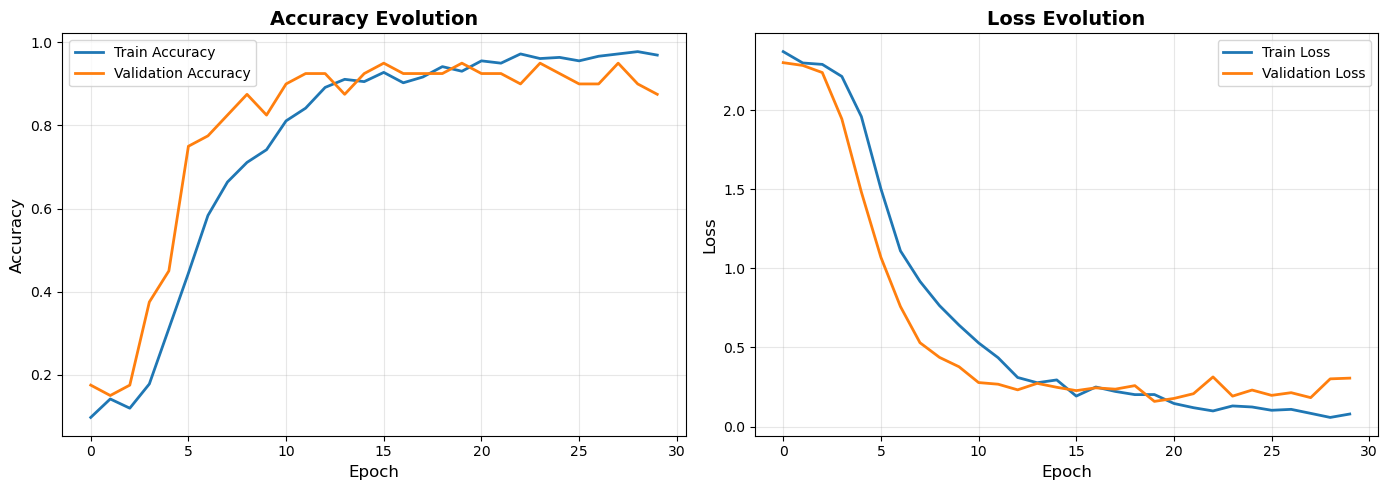

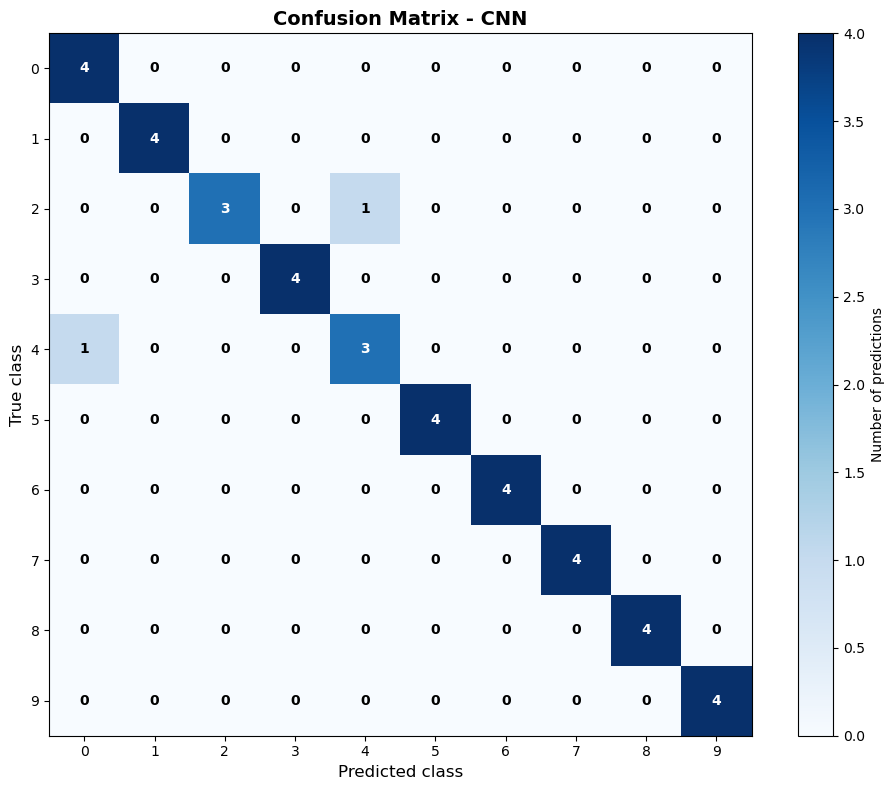


Model saved: hand_gesture_cnn_model.h5


In [3]:
# IMPORT LIBRARIES
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob


IMG_SIZE = 128
NUM_CLASSES = 10
BATCH_SIZE = 16
EPOCHS = 50


# LOAD DATASETS FROM FOLDERS :  Loads training images from a folder structure organized by class
def load_train_dataset(folder_path):

    images = []
    labels = []
    
    print(f"Loading training images from {folder_path}...")
    
    # Iterate through each class folder (0 to 9)
    total_images = 0
    for class_id in range(NUM_CLASSES):
        class_folder = os.path.join(folder_path, str(class_id))
        
        if not os.path.exists(class_folder):
            print(f"Warning: Folder {class_folder} not found")
            continue
        
        # Get all .jpg files in the class folder
        image_paths = glob.glob(os.path.join(class_folder, "*.jpg"))
        
        print(f"  Class {class_id}: {len(image_paths)} images")
        
        for img_path in image_paths:
            try:
                # Read and preprocess image
                img = cv2.imread(img_path)
                if img is None:
                    print(f"    Error: Unable to load {os.path.basename(img_path)}")
                    continue
                    
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                
                images.append(img)
                labels.append(class_id)
                total_images += 1
                
            except Exception as e:
                print(f"    Error loading {os.path.basename(img_path)}: {e}")
    
    # Convert to numpy arrays
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')
    
    print(f"\nTotal loaded: {total_images} images")
    print(f"Dataset shape: {images.shape}, Labels shape: {labels.shape}")
    
    return images, labels

#     Loads test images where files are directly stored in the folder/ Filename format: C_P_T.jpg where C is the class (0–9)
def load_test_dataset(folder_path):

    images = []
    labels = []
    
    image_paths = glob.glob(os.path.join(folder_path, "*.jpg"))
    
    if len(image_paths) == 0:
        raise ValueError(f"No images found in {folder_path}")
    
    print(f"\nLoading test images from {folder_path}...")
    print(f"Number of images found: {len(image_paths)}")
    
    for img_path in sorted(image_paths):
        try:
            # Extract class from filename
            filename = os.path.basename(img_path)
            class_label = int(filename.split('_')[0])
            
            # Read and preprocess image
            img = cv2.imread(img_path)
            if img is None:
                print(f"  Error: Unable to load {filename}")
                continue
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            
            images.append(img)
            labels.append(class_label)
            
        except Exception as e:
            print(f"  Error loading {filename}: {e}")
    
    # Convert to numpy arrays
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')
    
    print(f"Test dataset loaded: {images.shape}, Labels: {labels.shape}")
    
    return images, labels


# DATA PREPROCESSING : Normalizes data and converts labels to one-hot encoding
def preprocess_data(x_train, y_train, x_test, y_test):

    # Normalize pixel values [0, 255] -> [0, 1]
    x_train = x_train / 255.0
    x_test = x_test / 255.0
    
    # Convert labels to one-hot encoding
    y_train_cat = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_cat = keras.utils.to_categorical(y_test, NUM_CLASSES)
    
    print(f"\nAfter preprocessing:")
    print(f"x_train shape: {x_train.shape}")
    print(f"x_test shape: {x_test.shape}")
    print(f"y_train_cat shape: {y_train_cat.shape}")
    print(f"y_test_cat shape: {y_test_cat.shape}")
    
    return x_train, y_train_cat, x_test, y_test_cat


# CNN MODEL CONSTRUCTION : Builds a simple but effective CNN for multi-class classification/
# Architecture:
#    - 3 Conv2D + MaxPooling blocks with increasing filters
#    - Dropout layers to reduce overfitting
#    - Fully connected layers for final classification
def build_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):

    model = Sequential([
        # Block 1: Basic feature detection
        Conv2D(32, kernel_size=(3, 3), activation='relu',
               input_shape=input_shape, padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Block 2: Intermediate-level features
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Block 3: Complex features
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Flattening and classification
        Flatten(),
        
        # Dense layers with Dropout
        Dense(256, activation='relu'),
        Dropout(0.5),  # Regularization
        
        Dense(128, activation='relu'),
        Dropout(0.3),
        
        # Output layer (10 classes)
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model


# COMPILATION AND TRAINING : Compiles and trains the model using callbacks
def train_model(model, x_train, y_train_cat, x_test, y_test_cat):

    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    # Callbacks to improve training
    callbacks = [
        # Early stopping if no improvement
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        # Reduce learning rate on plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    # Training
    print("\n" + "="*60)
    print("START OF TRAINING")
    print("="*60)
    
    history = model.fit(
        x_train, y_train_cat,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(x_test, y_test_cat),
        callbacks=callbacks,
        verbose=1
    )
    
    return history


# MODEL EVALUATION : Detailed evaluation of the model on the test set
def evaluate_model(model, x_test, y_test_cat, y_test):

    print("\n" + "="*60)
    print("EVALUATION ON TEST SET")
    print("="*60)
    
    # Global evaluation
    test_loss, test_accuracy = model.evaluate(x_test, y_test_cat, verbose=0)
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    
    # Predictions
    y_pred_proba = model.predict(x_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Per-class metrics
    print(f"\n{'Class':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-" * 60)
    
    for c in range(NUM_CLASSES):
        tp = np.sum((y_test == c) & (y_pred == c))
        fp = np.sum((y_test != c) & (y_pred == c))
        fn = np.sum((y_test == c) & (y_pred != c))
        support = np.sum(y_test == c)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"{c:<8} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f} {support:<10}")
    
    return y_pred


# RESULTS VISUALIZATION : Visualizes accuracy and loss evolution during training
def plot_training_history(history):

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Accuracy Evolution', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('Loss Evolution', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# CONFUSION MATRIX
def plot_confusion_matrix(y_test, y_pred):
    
    confusion = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=int)
    
    for true, pred in zip(y_test, y_pred):
        confusion[true, pred] += 1
    
    plt.figure(figsize=(10, 8))
    plt.imshow(confusion, cmap='Blues', interpolation='nearest')
    plt.colorbar(label='Number of predictions')
    plt.xlabel('Predicted class', fontsize=12)
    plt.ylabel('True class', fontsize=12)
    plt.title('Confusion Matrix - CNN', fontsize=14, fontweight='bold')
    
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            plt.text(j, i, str(confusion[i, j]),
                     ha='center', va='center',
                     color='white' if confusion[i, j] > confusion.max()/2 else 'black',
                     fontweight='bold')
    
    plt.xticks(range(NUM_CLASSES))
    plt.yticks(range(NUM_CLASSES))
    plt.tight_layout()
    plt.show()


# FULL PIPELINE : Full pipeline: loading, training, validation, testing
def main():

    print("="*60)
    print("CNN FOR HAND GESTURE CLASSIFICATION")
    print("="*60)
    
    # 1. Load data
    x_train, y_train = load_train_dataset("Dataset/Train")
    x_test, y_test = load_test_dataset("Dataset/Test")
    
    # 2. Preprocessing
    x_train, y_train_cat, x_test, y_test_cat = preprocess_data(
        x_train, y_train, x_test, y_test
    )
    
    # 3. Build model
    print("\n" + "="*60)
    print("BUILDING CNN MODEL")
    print("="*60)
    model = build_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3))
    model.summary()
    
    # 4. Training
    history = train_model(model, x_train, y_train_cat, x_test, y_test_cat)
    
    # 5. Evaluation
    y_pred = evaluate_model(model, x_test, y_test_cat, y_test)
    
    # 6. Visualization
    plot_training_history(history)
    plot_confusion_matrix(y_test, y_pred)
    
    # 7. Save model
    model.save('hand_gesture_cnn_model.h5')
    print("\nModel saved: hand_gesture_cnn_model.h5")
    
    return model, history


# EXECUTION
if __name__ == "__main__":
    model, history = main()
